In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydaptivefiltering as pdf

In [2]:
def generate_qam(n, order=16):
    side = int(np.sqrt(order))
    indices = np.random.randint(0, order, n)
    x = np.arange(side) - (side - 1) / 2
    re, im = np.meshgrid(x, x)
    const = (re + 1j * im).flatten()
    # Normalização para potência unitária
    const /= np.sqrt(np.mean(np.abs(const)**2))
    return const[indices]

# Parâmetros de simulação
n_samples = 15000
s = generate_qam(n_samples)

# Canal seletivo em frequência (introduz ISI)
h_channel = np.array([1.0, 0.4j, -0.2, 0.1j])
x_distorted = np.convolve(s, h_channel, mode='same')
x_distorted += 0.005 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

In [3]:
# Configuração 1: Caso clássico (Similar ao CMA)
w_init_1 = np.zeros(11, dtype=complex); w_init_1[5] = 1.0
godard_1 = pdf.Godard(filter_order=10, step=0.001, p_exponent=2, q_exponent=2, w_init=w_init_1)
res1 = godard_1.optimize(x_distorted)

# Configuração 2: Godard com p=1, q=2 (Mais robusto a outliers)
w_init_2 = np.zeros(11, dtype=complex); w_init_2[5] = 1.0
godard_2 = pdf.Godard(filter_order=10, step=0.001, p_exponent=1, q_exponent=2, w_init=w_init_2)
res2 = godard_2.optimize(x_distorted)

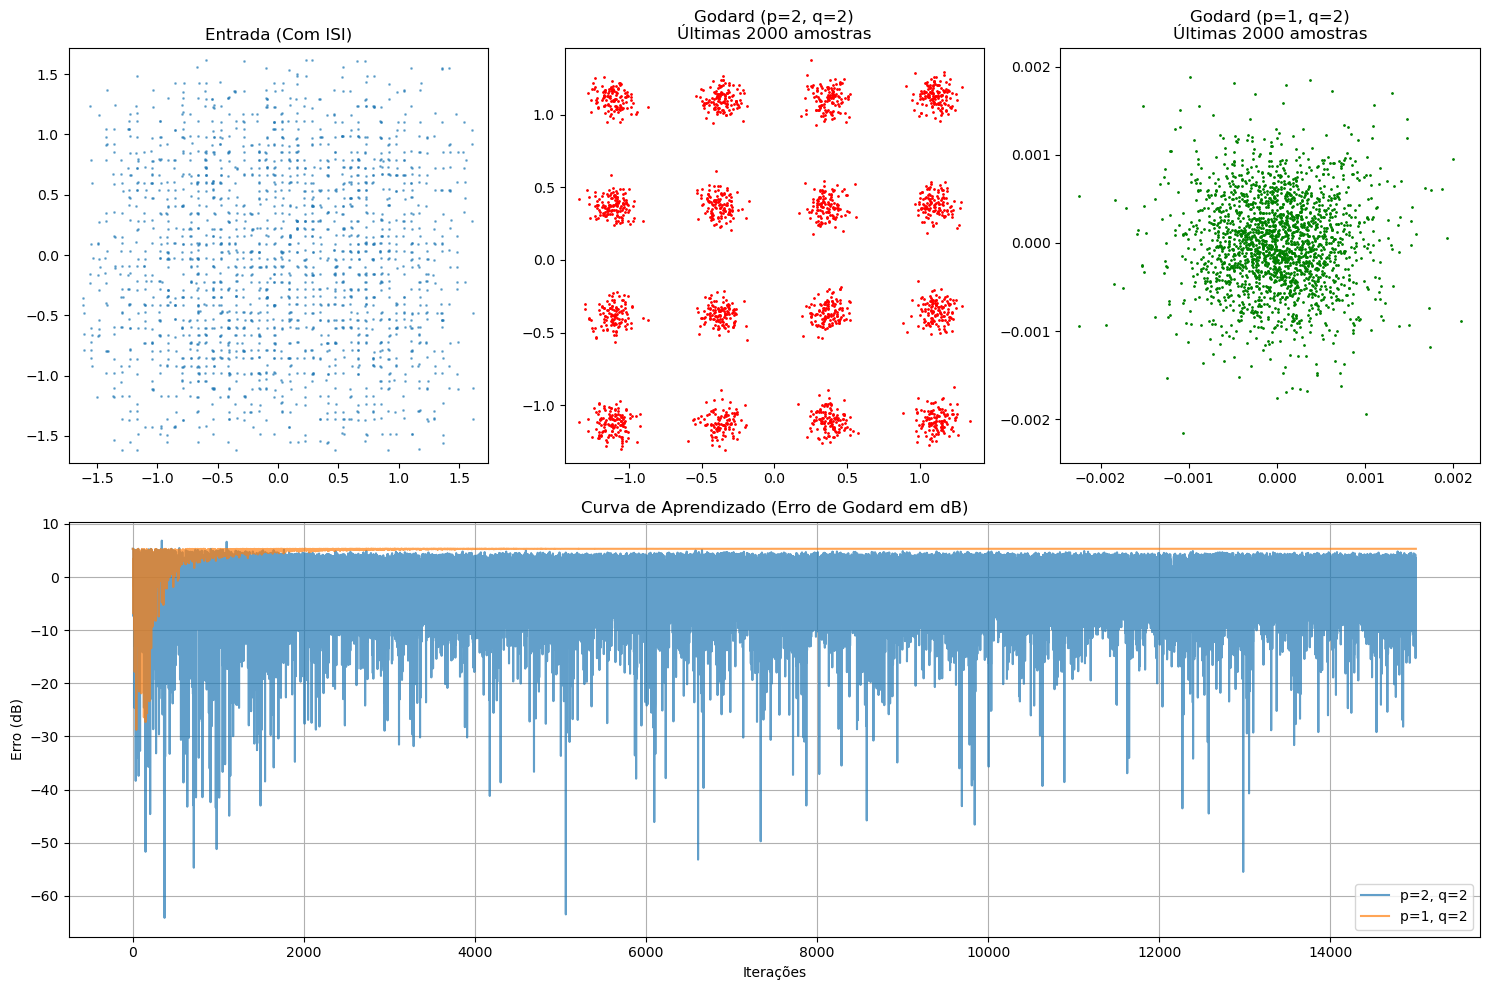

In [8]:
plt.figure(figsize=(15, 10))

# 1. Sinal Distorcido
plt.subplot(2, 3, 1)
plt.scatter(x_distorted[:2000].real, x_distorted[:2000].imag, s=1, alpha=0.5)
plt.title("Entrada (Com ISI)")
plt.axis('equal')

# 2. Resultado Godard p=2, q=2
plt.subplot(2, 3, 2)
plt.scatter(res1["outputs"][-2000:].real, res1["outputs"][-2000:].imag, s=1, color='red')
plt.title("Godard (p=2, q=2)\nÚltimas 2000 amostras")
plt.axis('equal')

# 3. Resultado Godard p=1, q=2
plt.subplot(2, 3, 3)
plt.scatter(res2["outputs"][-2000:].real, res2["outputs"][-2000:].imag, s=1, color='green')
plt.title("Godard (p=1, q=2)\nÚltimas 2000 amostras")
plt.axis('equal')

# 4. Evolução do Erro
plt.subplot(2, 1, 2)
plt.plot(10 * np.log10(np.abs(res1["errors"])**2 + 1e-10), label="p=2, q=2", alpha=0.7)
plt.plot(10 * np.log10(np.abs(res2["errors"])**2 + 1e-10), label="p=1, q=2", alpha=0.7)
plt.title("Curva de Aprendizado (Erro de Godard em dB)")
plt.xlabel("Iterações")
plt.ylabel("Erro (dB)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()